# DACON 음향 데이터 COVID-19 검출 AI 경진대회
[참고 | [Private 6위, 0.60553] DNN 코드 공유](https://dacon.io/competitions/official/235910/codeshare/5484?page=1&dtype=recent)

### 사용 라이브러리

In [28]:
import numpy as np
import pandas as pd
import os
import librosa

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

### Data Load

In [2]:
base_path = "./open/"
train = pd.read_csv(base_path+"train_data.csv")
test = pd.read_csv(base_path+"test_data.csv")

train.shape, test.shape

((3805, 6), (5732, 5))

### Pre-Processing

In [4]:
features = []
log_specgrams_hp = []
feature_delta = [] # feature 3
melspectrogram_list = [] # feature 1
harmonic_percussive_list = [] # feature 2

for uid in tqdm(train["id"]):
    root_path = os.path.join(base_path, "train")
    path = os.path.join(root_path, str(uid).zfill(5)+".wav")
    
    # wav 파일 load
    y, sr = librosa.load(path, sr=16000)
    
    # melspectrogram 추출
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=32)
    # 로그스케일링 된 melspectrogram의 델타값
    delta = []
    for e in melspectrogram:
        delta.append(np.mean(librosa.feature.delta(e)))
    feature_delta.append(delta)
    # 로그 스케일링
    feature_log_scale = librosa.power_to_db(S=melspectrogram, ref=1.0)
    # feature 1: 추출된 melspectrogram드르이 평균
    temp = []
    for e in feature_log_scale:
        temp.append(np.mean(e))
    melspectrogram_list.append(temp)
    
    # feature 2: (운율적 소리(harmonic)+두드리는 소리(percussive)의 구성 요소) 평균
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    melspectrogram_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels=32)
    melspectrogram_percussive = librosa.feature.melspectrogram(y_percussive, n_mels=32)
    log_harmonic = librosa.amplitude_to_db(melspectrogram_harmonic)
    log_percussive = librosa.amplitude_to_db(melspectrogram_percussive)
    log_hp = np.average([log_harmonic, log_percussive], axis=0)
    
    temp = []
    for e in log_hp:
        temp.append(np.mean(e))
    harmonic_percussive_list.append(temp)    

  0%|          | 0/3805 [00:00<?, ?it/s]

C:\Users\spec3\AppData\Local\Temp\ipykernel_29760\3881416037.py:31: FutureWarning: Pass y=[ 1.2870407e-06  2.0044620e-06  1.5876038e-06 ... -2.6456871e-06
  7.2691698e-08 -2.9501330e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels=32)
C:\Users\spec3\AppData\Local\Temp\ipykernel_29760\3881416037.py:32: FutureWarning: Pass y=[-1.2870428e-06 -2.0044622e-06 -1.5876014e-06 ...  8.2185039e-07
  1.3325483e-06  1.6774512e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram_percussive = librosa.feature.melspectrogram(y_percussive, n_mels=32)
C:\Users\spec3\AppData\Local\Temp\ipykernel_29760\3881416037.py:31: FutureWarning: Pass y=[-1.5769877e-12 -1.5193184e-12 -1.9539214e-12 ... -1.0788832e-04
 -1.5833076e-04 -1.7153863e-04] as keyword args. From version 0.10 passing these as positional arguments will

In [5]:
# 오디오 Feature 추가
f_list1 = pd.DataFrame(melspectrogram_list)
f_list2 = pd.DataFrame(harmonic_percussive_list)
f_list3 = pd.DataFrame(feature_delta)

In [8]:
f_list1.columns = ["melspectrogram_1_"+str(x) for x in range(1, 33)]
f_list2.columns = ["melspectrogram_2_"+str(x) for x in range(1, 33)]
f_list3.columns = ["melspectrogram_3_"+str(x) for x in range(1, 33)]

In [12]:
melspectrogram_train_df = pd.concat([f_list1,f_list2,f_list3], axis=1)
train_df = pd.concat([train, melspectrogram_train_df], axis=1)

In [14]:
train_df.head(5)

id  age  gender  respiratory_condition  fever_or_muscle_pain  covid19  \
0   1   24  female                      0                     1        0   
1   2   51    male                      0                     0        0   
2   3   22    male                      0                     0        0   
3   4   29  female                      1                     0        0   
4   5   23    male                      0                     0        0   

   melspectrogram_1_1  melspectrogram_1_2  melspectrogram_1_3  \
0          -31.943413          -27.335651          -23.652283   
1          -18.772213          -17.970600          -19.152706   
2          -41.755840          -37.208641          -36.034973   
3          -36.795872          -28.668598          -27.015005   
4          -50.650784          -46.894409          -47.190170   

   melspectrogram_1_4  ...  melspectrogram_3_23  melspectrogram_3_24  \
0          -20.332117  ...         1.551721e-05         5.001302e-05   
1          -20.261648  ...         4.808880e-07         3.241044e-07   
2          -36.101788  ...        -2.077132e-08        -1.249289e-08   
3          -27.315031  ...        -8.004472e-08        -6.886885e-08   
4          -48.408485  ...        -5.674101e-10        -8.946563e-10   

   melspectrogram_3_25  melspectrogram_3_26  melspectrogram_3_27  \
0         7.300529e-05         6.368942e-05         8.467526e-05   
1         2.775657e-07         2.403397e-07         1.801275e-07   
2        -1.005954e-08        -6.208817e-09        -1.373466e-09   
3        -4.426233e-08        -2.452074e-08        -3.148728e-08   
4         5.834516e-10        -1.668314e-10         1.389479e-09   

   melspectrogram_3_28  melspectrogram_3_29  melspectrogram_3_30  \
0         2.460767e-05         1.935706e-05         3.276046e-05   
1         1.468669e-07         1.040892e-07         3.793937e-08   
2        -1.762301e-09        -2.323603e-09        -1.048914e-09   
3        -4.078213e-08        -1.627670e-08        -1.823432e-08   
4        -1.114242e-09         2.274453e-11         3.102881e-10   

   melspectrogram_3_31  melspectrogram_3_32  
0         1.080332e-05         9.988543e-07  
1         2.792552e-08        -5.082057e-09  
2        -2.308708e-10        -4.273706e-11  
3        -7.824335e-09        -9.221319e-10  
4         2.110314e-10         8.379827e-11  

[5 rows x 102 columns]

In [16]:
# test
features = []
log_specgrams_hp = []
feature_delta = [] # feature 3
melspectrogram_list = [] # feature 1
harmonic_percussive_list = [] # feature 2

for uid in tqdm(test["id"]):
    root_path = os.path.join(base_path, "test")
    path = os.path.join(root_path, str(uid).zfill(5)+".wav")
    
    # wav 파일 load
    y, sr = librosa.load(path, sr=16000)
    
    # melspectrogram 추출
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=32)
    # 로그스케일링 된 melspectrogram의 델타값
    delta = []
    for e in melspectrogram:
        delta.append(np.mean(librosa.feature.delta(e)))
    feature_delta.append(delta)
    # 로그 스케일링
    feature_log_scale = librosa.power_to_db(S=melspectrogram, ref=1.0)
    # feature 1: 추출된 melspectrogram드르이 평균
    temp = []
    for e in feature_log_scale:
        temp.append(np.mean(e))
    melspectrogram_list.append(temp)
    
    # feature 2: (운율적 소리(harmonic)+두드리는 소리(percussive)의 구성 요소) 평균
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    melspectrogram_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels=32)
    melspectrogram_percussive = librosa.feature.melspectrogram(y_percussive, n_mels=32)
    log_harmonic = librosa.amplitude_to_db(melspectrogram_harmonic)
    log_percussive = librosa.amplitude_to_db(melspectrogram_percussive)
    log_hp = np.average([log_harmonic, log_percussive], axis=0)
    
    temp = []
    for e in log_hp:
        temp.append(np.mean(e))
    harmonic_percussive_list.append(temp)    

  0%|          | 0/5732 [00:00<?, ?it/s]

C:\Users\spec3\AppData\Local\Temp\ipykernel_29760\4237132186.py:32: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels=32)
C:\Users\spec3\AppData\Local\Temp\ipykernel_29760\4237132186.py:33: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram_percussive = librosa.feature.melspectrogram(y_percussive, n_mels=32)
C:\Users\spec3\AppData\Local\Temp\ipykernel_29760\4237132186.py:32: FutureWarning: Pass y=[-1.9076611e-08  1.9468470e-08 -7.6799815e-08 ... -8.3941580e-07
 -1.0958861e-06  2.7444153e-07] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels=32)
C:\Users\spec3\AppData\Local\Temp\ipykernel_

In [17]:
# 오디오 Feature 추가
f_list1 = pd.DataFrame(melspectrogram_list)
f_list2 = pd.DataFrame(harmonic_percussive_list)
f_list3 = pd.DataFrame(feature_delta)

In [18]:
f_list1.columns = ["melspectrogram_1_"+str(x) for x in range(1, 33)]
f_list2.columns = ["melspectrogram_2_"+str(x) for x in range(1, 33)]
f_list3.columns = ["melspectrogram_3_"+str(x) for x in range(1, 33)]

In [19]:
melspectrogram_test_df = pd.concat([f_list1,f_list2,f_list3], axis=1)
test_df = pd.concat([test, melspectrogram_test_df], axis=1)

In [20]:
test_df.head()

id  age  gender  respiratory_condition  fever_or_muscle_pain  \
0  3806   48  female                      1                     0   
1  3807   24  female                      0                     0   
2  3808   29    male                      0                     0   
3  3809   39  female                      0                     0   
4  3810   34    male                      0                     0   

   melspectrogram_1_1  melspectrogram_1_2  melspectrogram_1_3  \
0          -55.853134          -55.158051          -54.891762   
1          -46.948128          -46.494526          -46.730667   
2          -99.176407          -93.005913          -91.820778   
3          -33.959797          -27.807213          -26.108114   
4          -33.321808          -29.476269          -30.429527   

   melspectrogram_1_4  melspectrogram_1_5  ...  melspectrogram_3_23  \
0          -54.874367          -54.994320  ...         0.000000e+00   
1          -46.501385          -46.066654  ...         4.068705e-10   
2          -92.210541          -93.268394  ...        -4.520774e-13   
3          -28.486483          -29.118986  ...        -9.174222e-10   
4          -30.836193          -31.185854  ...        -5.356627e-10   

   melspectrogram_3_24  melspectrogram_3_25  melspectrogram_3_26  \
0         3.043538e-12         7.608845e-13         0.000000e+00   
1        -3.715323e-10        -7.672049e-10        -1.703404e-10   
2        -3.750947e-13        -7.825289e-13        -1.284776e-12   
3         2.168453e-09        -4.170101e-10         5.560135e-11   
4         7.791457e-10         3.895728e-10         0.000000e+00   

   melspectrogram_3_27  melspectrogram_3_28  melspectrogram_3_29  \
0         0.000000e+00        -3.043538e-12        -7.608845e-13   
1         1.796148e-09         2.624169e-10         1.179117e-10   
2        -6.738704e-13        -9.572461e-13        -1.115856e-12   
3        -6.950168e-12        -5.125749e-11        -4.969370e-10   
4         1.217415e-10         8.521906e-11         6.087076e-12   

   melspectrogram_3_30  melspectrogram_3_31  melspectrogram_3_32  
0        -7.608845e-13         3.091093e-13        -5.944410e-15  
1        -4.361051e-11         1.998812e-11        -1.802107e-11  
2        -6.283318e-13        -1.451943e-12        -3.377899e-13  
3         2.293556e-10         1.390034e-10         4.734802e-11  
4         0.000000e+00        -2.434830e-11        -1.217415e-11  

[5 rows x 101 columns]

### Train

In [22]:
x_train = train_df.drop(columns=["id", "covid19"])
y_train = train_df["covid19"]

In [45]:
x_train = pd.get_dummies(x_train, columns=["gender"], drop_first=False)

In [54]:
model = Sequential(name="Covid19_DNN")
model.add(Dense(512, activation="relu", input_shape=(x_train.shape[0], x_train.shape[1])))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(10, activation="relu"))
model.add(Dense(2, activation="sigmoid"))

In [55]:
model.summary()

Model: "Covid19_DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 3805, 512)         52736     
_________________________________________________________________
dense_14 (Dense)             (None, 3805, 256)         131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 3805, 256)         0         
_________________________________________________________________
dense_15 (Dense)             (None, 3805, 128)         32896     
_________________________________________________________________
dense_16 (Dense)             (None, 3805, 64)          8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 3805, 64)          0         
_________________________________________________________________
dense_17 (Dense)             (None, 3805, 10)          

In [56]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

In [58]:
with tf.device("/device:GPU:0"):
    histroy = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stop])

Epoch 1/100
48/48 [==============================] - 2s 9ms/step - loss: 0.7508 - accuracy: 0.8811 - val_loss: 0.3203 - val_accuracy: 0.9080
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 0.3339 - accuracy: 0.9149 - val_loss: 0.3312 - val_accuracy: 0.9080
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 0.3159 - accuracy: 0.9215 - val_loss: 0.3192 - val_accuracy: 0.9080
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.3045 - accuracy: 0.9218 - val_loss: 0.3229 - val_accuracy: 0.9080
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2987 - accuracy: 0.9215 - val_loss: 0.3163 - val_accuracy: 0.9080
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2918 - accuracy: 0.9225 - val_loss: 0.3113 - val_accuracy: 0.9080
Epoch 7/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2863 - accuracy: 0.9225 - val_loss: 0.3118 - val_accuracy: 0.9080
Epoch 8/100
4

### Evalutate

In [60]:
test_loss, test_acc = model.evaluate(x_train, y_train)

119/119 [==============================] - 0s 3ms/step - loss: 0.2735 - accuracy: 0.9198


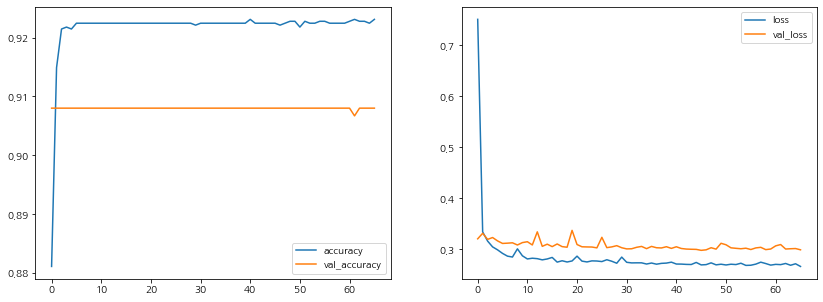

In [62]:
hist_df = pd.DataFrame(histroy.history)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hist_df[["accuracy", "val_accuracy"]].plot(ax=ax[0])
hist_df[["loss", "val_loss"]].plot(ax=ax[1])
plt.show()

### Submission

In [63]:
x_test = test_df.drop(columns=["id"])
x_test = pd.get_dummies(x_test, columns=["gender"], drop_first=False)

In [64]:
pred = model.predict(x_test)

In [81]:
y_pred = pd.DataFrame(np.where((pred>0.84), 0, 1))
y_pred = pd.DataFrame(y_pred.iloc[:, 0])

In [86]:
sub = pd.read_csv("./open/sample_submission.csv")
sub["covid19"] = y_pred
sub.to_csv("sub_dnn.csv", index=False)